In [44]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import math
from IPython.display import display, HTML

In [45]:
class FCT:

    def __init__(self, folder, toponame, flownum, loads, algs):
        self.flownum = flownum
        self.loads = loads
        self.algs = algs
        self.raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
        for alg_i in range(len(algs)):
            for load_i in range(len(loads)):
                alg = algs[alg_i]
                load = loads[load_i]
                # print("tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                self.raw_data[alg_i][load_i] = \
                    self.parse_trace(folder, filename="tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                    
    # At least two
    def plotting_mean_FCT(self):
        plt.figure(figsize=(8,5))
        # base = [15,25]
        # time = 10
        # plt.yticks([self.scaling(x, base, time) for x in [10,15,20,25,30,40]],[10,15,20,25,30,40])
        plt.yscale('log', basey= 10)
        # plt.ylim(10, 60)
        # plt.yticks(np.arange(min(x), max(x)+1, 1.0))
        plt.grid()
        plt.xlabel("Link utilization")
        plt.ylabel("Normalized FCT")
        plt.title("Normalized FCT")
        for alg_i in range(len(self.algs)):
            alg = self.algs[alg_i]
            load_means = [0 for i in range(len(self.loads))]
            for load_i in range(len(self.loads)):
                load = self.loads[load_i]
                load_means[load_i] = self.raw_data[alg_i][load_i]["Normalized FCT"].mean()
            #scaled_load_means = [self.scaling(x, base, time) for x in load_means]
            #plt.plot(self.loads, scaled_load_means, label=alg)
            plt.plot(self.loads, load_means, label=alg)
        plt.legend(loc='best')
        plt.show()
    
    # Normalized FCT = Actual FCT / min FCT
    # min FCT = flow_size / max bandwidth
    def parse_trace(self, dir, filename):
        col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
                   "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
        df = pd.read_csv(dir+filename, sep = ' ', header = None)
        df.columns = col
        df["Normalized FCT"] = 40 * 1e9 / df["Average rate"]
        return df
    
    def get_load_id(self, load):
        return self.loads.index(load)
    
    def get_alg_id(self, alg):
        return self.algs.index(alg)
    
    def humanbytes(self, B):
        B = float(B)
        KB = float(1000)
        MB = float(KB ** 2)
        GB = float(KB ** 3)
        TB = float(KB ** 4) 

        if B < KB:
            return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
        elif KB <= B < MB:
            return '{0:.2f} KB'.format(B/KB)
        elif MB <= B < GB:
            return '{0:.2f} MB'.format(B/MB)
        elif GB <= B < TB:
            return '{0:.2f} GB'.format(B/GB)
        elif TB <= B:
            return '{0:.2f} TB'.format(B/TB)
        
    def plot_FCT_flowsize(self, alg, load, color=None, scale=[0,0], label=None):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df=self.raw_data[alg_id][load_id]
        y = df['Normalized FCT']
        x = df['tmp_pkts']
        plt.yscale('log')
        plt.scatter(x, y, color=color, label=label)
        plt.xlabel('flow size')
        plt.ylabel('Normalized FCT')
        plt.legend()
        plt.show()
        
    def scaling(self, x, base, time):
        if (x < base[0]):
            return base[0] - x / time
        elif (x > base[1]):
            return base[1] + x / time
        else:
            return x
        return x if (base == 0 or x<base) else base + x / time
    
    def plot_one_FCT_percentile(self, alg, load, percentile, flow_size, scale=[0,0], isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # print(label)
            # display(seg_data)
            # 16 indicate col 'Normalized FCT' 
            # print(res.iloc[[math.ceil((res.shape[0]-1) * 0.95)]])
            # selected_flow.append(res.iloc[math.ceil((res.shape[0]-1) * 0.95), 16])
            selected_flow.append(res.iloc[:, 16].mean())
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size')
            plt.ylabel('Normalized FCT')
            #plt.title("load:"+str(load)+" percentile:"+str(percentile))
            plt.title("load:"+str(load)+" mean")
            plt.grid()
            plt.legend()
            #plt.yticks([0,50,100,150,200])
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size])
            plt.show()
            
    def plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size, scale=[0,0]):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_percentile(alg , load, percentile, flow_size, scale, True)
            else:
                self.plot_one_FCT_percentile(alg , load, percentile, flow_size, scale, False)
                
    def plot_one_FCT_load(self, alg, loads, flow_lim, isLast=False):
        alg_id=self.get_alg_id(alg)
        df = self.raw_data[alg_id][:]
        y = []
        for load in loads:
            load_id=self.get_load_id(load)
            df_one = df[load_id]
            y.append(df_one[df_one['tmp_pkts']<flow_lim]['Normalized FCT'].mean())
        plt.yscale('log')
        plt.plot(loads, y, label=alg)
        if (isLast):
            plt.xlabel('load')
            plt.ylabel('Normalized FCT')
            plt.grid()
            plt.legend()
            plt.show()
            
    def plot_FCT_load(self, algs, loads, flow_lim):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_load(alg, loads, flow_lim, True)
            else:
                self.plot_one_FCT_load(alg, loads, flow_lim, False)       
            

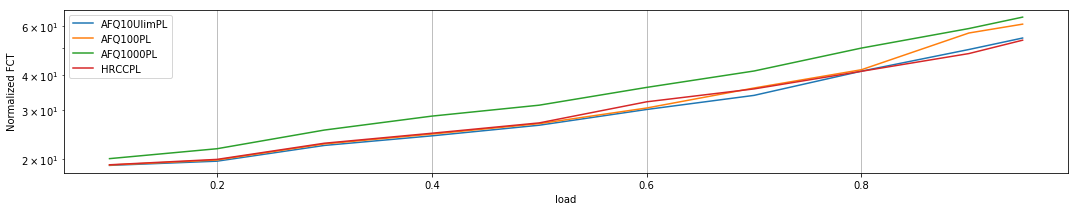

In [47]:
if __name__ == '__main__':
    FCT_analysis = FCT("/home/ovs2/lining/Gearbox/automatic/", \
                       "Topology-incast-singlenode.tcl",\
                       1000, \
                       [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], \
                       ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"])
    # ["DropTail",  "AFQ10PL","AFQ10UlimPL", "AFQ100PL", "AFQ1000PL", "HRCCPL"]
    FCT_analysis.plot_FCT_load(["AFQ10UlimPL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                                   [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], 50)

In [ ]:
if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    # print([FCT_analysis.humanbytes(i*1500) for i in flow_size])
    algs=["DropTail"]

    
    FCT_analysis_small = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode-small.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_small.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)
    
    
    FCT_analysis_normal = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_normal.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)        
    
    
    FCT_analysis_big = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode-big.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_big.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)    

In [ ]:
if __name__ == '__main__':
    FCT_analysis = FCT("/home/ovs2/lining/Gearbox/automatic/obsolete/", "Topology-incast-singlenode.tcl",\
                   1000, \
                   [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], \
                   # ["AFQ10", "HRCC", "DropTail", "AFQ100", "AFQ1000",\
                   ["DropTail-100", "DropTail-200", "DropTail", "DropTail-500", "DropTail-1000", "DropTail-1500", "DropTail-2000"])
    # Byte
    flow_size=[0, 6, 13, 19, 33, 53, 133, 1333, 3333, 6667, float('inf')]
    print([FCT_analysis.humanbytes(i*1500) for i in flow_size])
    #algs=["AFQ10", "HRCC", "DropTail", "AFQ100", "AFQ1000"]
    #algs=["HRCC", "AFQ1000", "AFQ100"]
    algs=["DropTail-100", "DropTail-200", "DropTail", "DropTail-500", "DropTail-1000", "DropTail-1500", "DropTail-2000"]
    # when scale = [0,0], there is no adjust to the graph
    scale=[150,100]
    scale=[0,0]
    for load in [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95]:
        FCT_analysis.plot_FCT_percentile_fix_load(algs, load, .95, flow_size, scale)

    FCT_analysis.plotting_mean_FCT()

    for alg in algs:
        FCT_analysis.plot_FCT_flowsize(alg, 0.5, label=alg, scale=[0, 0])